## **Road Sign Classification with Keras and Deep Learning**
Road sign classification is the process of automatically recognizing traffic signs along the road, including speed limit signs, yield signs, merge signs, etc. Being able to automatically recognize traffic signs enables us to build “smarter cars”.

Self-driving cars need traffic sign recognition in order to properly parse and understand the roadway. Similarly, “driver alert” systems inside cars need to understand the roadway around them to help aid and protect drivers.

### **GTSRB - German Traffic Sign Recognition Dataset**
The [GTSRB](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset consists of **43** traffic sign classes and nearly 50,000 images.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
# Store data, labels in the list
data=[]
labels=[]

# Road Sign: 43 Classes
classes = 43

## **Preprocess the images**
Preprocess all the training images are store into numpy arrays. I'll also get labels of images from paths. And convert targets to one-hot form as is required by keras. 

One of the limitations of the CNN model is that they cannot be trained on a different dimension of images. So, it is mandatory to have same dimension images in the dataset.

In [3]:
%cd gtsrb-german-traffic-sign
cur_path = os.getcwd()
cur_path 

/content/gtsrb-german-traffic-sign


'/content/gtsrb-german-traffic-sign'

#### **Retrieving the images and their labels**

In [4]:
for i in range(classes):
    path = os.path.join(cur_path,'Train',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '//'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(e)

#### **Converting lists into numpy arrays**

In [5]:
data = np.array(data)
labels = np.array(labels)

In [6]:
# Save labels & data for future use
os.mkdir('training')

np.save('./training/data',data)
np.save('./training/target',labels)

In [7]:
# Load data & Labels
data = np.load('./training/data.npy')
labels = np.load('./training/target.npy')

In [8]:
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


#### **Splitting training and testing dataset**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


#### **Converting the labels into one hot encoding**

In [11]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

### **Build a CNN model**
I'll be using keras package to build CNN model. CNN is best for image classification purposes.

**The architecture of our model is:**

- 2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)
- MaxPool2D layer ( pool_size=(2,2))
- Dropout layer (rate=0.25)
- 2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)
- MaxPool2D layer ( pool_size=(2,2))
- Dropout layer (rate=0.25)
- Flatten layer to squeeze the layers into 1 dimension
- Dense Fully connected layer (256 nodes, activation=”relu”)
- Dropout layer (rate=0.5)
- Dense layer (43 nodes, activation=”softmax”)

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
# 43 classes for 43 in the Dense
model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

### **Compilation of the model**

Before training the model, we need to configure the model the learning algorithm and compile it. Compile the model with **Adam optimizer** which performs well and loss is "categorical_crossentropy" because we have multiple classes to categorize.

We need to specify:
- **loss** : Loss function is used to find error or deviation in the learning process. Keras requires loss function during model compilation process and optimize it. We cannot use error percentage as it is not continuous and thus non differentiable. We therefore use **categorical_crossentropy**
- **optimizer** : Optimization is an important process which optimize the input weights by comparing the prediction and the loss function. adam optimizer for training the network.
- **metric** : Metrics is used to evaluate the performance of your model. It is similar to loss function, but not used in training process. Since we are dealing with a classification problem, our metric is accuracy.

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Train and validate the model**

After building the model architecture, we then train the model using **model.fit()**. I tried with batch size 32 and 64. Our model performed better with 64 batch size. And after 15 epochs the accuracy was stable.

In [14]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
981/981 [==============================] - 37s 5ms/step - loss: 3.4820 - accuracy: 0.2930 - val_loss: 0.6995 - val_accuracy: 0.8129
Epoch 2/20
981/981 [==============================] - 4s 4ms/step - loss: 0.9859 - accuracy: 0.7166 - val_loss: 0.3736 - val_accuracy: 0.9009
Epoch 3/20
981/981 [==============================] - 4s 4ms/step - loss: 0.6452 - accuracy: 0.8066 - val_loss: 0.2349 - val_accuracy: 0.9355
Epoch 4/20
981/981 [==============================] - 4s 4ms/step - loss: 0.4997 - accuracy: 0.8510 - val_loss: 0.1606 - val_accuracy: 0.9521
Epoch 5/20
981/981 [==============================] - 4s 4ms/step - loss: 0.4069 - accuracy: 0.8775 - val_loss: 0.1390 - val_accuracy: 0.9598
Epoch 6/20
981/981 [==============================] - 4s 4ms/step - loss: 0.3275 - accuracy: 0.9065 - val_loss: 0.1086 - val_accuracy: 0.9694
Epoch 7/20
981/981 [==============================] - 4s 4ms/step - loss: 0.2866 - accuracy: 0.9198 - val_loss: 0.0876 - val_accuracy: 0.9733
Epoch

### **Plotting graphs for accuracy**

Our model got a 95% accuracy on the training dataset. With matplotlib, we plot the graph for accuracy and the loss.

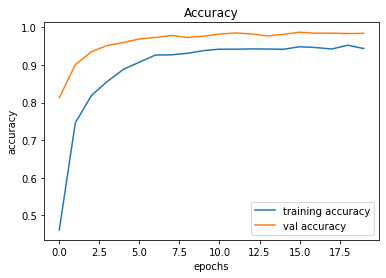

In [15]:
# Accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

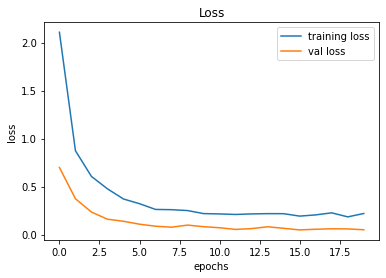

In [16]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### **Test the model with test dataset**

In [17]:
   # Let's do testing on Test data
   def testing(test_dataset):
    y_test = pd.read_csv(test_dataset)
    label = y_test["ClassId"].values
    imgs = y_test["Path"].values
    data=[]
    for img in imgs:
        image = Image.open(img)
        image = image.resize((30,30))
        data.append(np.array(image))
    X_test=np.array(data)
    return X_test,label

In [18]:
X_test, label = testing('Test.csv')

In [19]:
Y_pred = np.argmax(model.predict(X_test), axis=-1)
Y_pred

array([16,  1, 38, ...,  2,  7, 10])

### **Accuracy with the test data**

In [20]:
print(accuracy_score(label, Y_pred))

0.950910530482977


### **Save the model**
Save the model that we have trained using the Keras model.save() function.

In [21]:
model.save("./training/traffic_classifier.h5")

### **Load the model**

In [22]:
model = load_model('./training/traffic_classifier.h5')

In [23]:
# Classes of trafic signs
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [24]:
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
    X_test=np.array(data)
    Y_pred = np.argmax(model.predict(X_test), axis=-1)
    return image,Y_pred

Classify Road Sign:  Speed limit (70km/h)


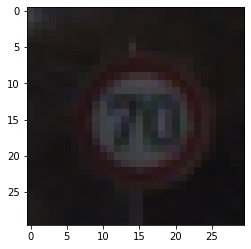

In [25]:
plot,prediction = test_on_img(r'/content/gtsrb-german-traffic-sign/Test/00020.png')
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("Classify Road Sign: ", classes[a])
plt.imshow(plot)
plt.show()